## Importing packages

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import metrics
import os
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from patsy import dmatrices
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sqlalchemy import create_engine
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import chi2_contingency
from IPython import display

pd.options.display.max_columns = None

import warnings
warnings.filterwarnings('ignore')

import getpass
password = getpass.getpass()

connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

········


## Loading data from sql

In [2]:
query = '''SELECT * from credit_card_classification.credit_card_data;'''

data = pd.read_sql_query(query, engine)

## Data exploration

In [3]:
data.head(7)

,customer_number,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982
5,6,No,Air Miles,Letter,Medium,1,No,High,3,1,4,No,1114.75,1847,1365,750
6,7,No,Air Miles,Letter,Medium,1,No,Medium,2,1,3,No,283.75,468,188,347


In [4]:
data.shape

(17976, 16)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17976 entries, 0 to 17975
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_number       17976 non-null  int64  
 1   offer_accepted        17976 non-null  object 
 2   reward                17976 non-null  object 
 3   mailer_type           17976 non-null  object 
 4   income_level          17976 non-null  object 
 5   bank_accounts_open    17976 non-null  int64  
 6   overdraft_protection  17976 non-null  object 
 7   credit_rating         17976 non-null  object 
 8   credit_cards_held     17976 non-null  int64  
 9   homes_owned           17976 non-null  int64  
 10  household_size        17976 non-null  int64  
 11  own_your_home         17976 non-null  object 
 12  average_balance       17976 non-null  float64
 13  q1_balance            17976 non-null  int64  
 14  q2_balance            17976 non-null  int64  
 15  q3_balance         

We observe there are a total of 17976 entries and there are not null values.

## Exploring categoricals

In [6]:
data_cat = data.select_dtypes('object')
data_cat.head()

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
0,No,Air Miles,Letter,High,No,High,No
1,No,Air Miles,Letter,Medium,No,Medium,Yes
2,No,Air Miles,Postcard,High,No,Medium,Yes
3,No,Air Miles,Letter,Medium,No,High,No
4,No,Air Miles,Letter,Medium,No,Medium,Yes


In [7]:
def categoricals_distribution(data):
    for x in data_cat:
        plt.subplots(figsize=(8, 4))
        sns.countplot(data_cat[x], palette="Set3")
        sns.set(font_scale=1.15)
        print(' \n{} {}\n\n{}\n{}\n'.format('Column:',x,'Distribution:',(data_cat[x].value_counts(normalize=True).round(2).to_string())))
        plt.ylabel('')
        plt.xlabel('')
        plt.show()

 
Column: offer_accepted

Distribution:
No     0.94
Yes    0.06



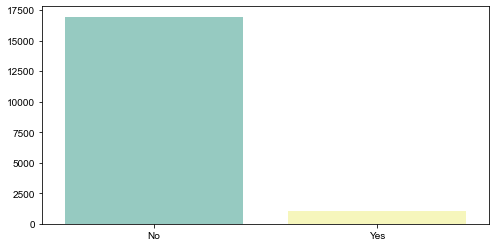

 
Column: reward

Distribution:
Air Miles    0.34
Cash Back    0.33
Points       0.33



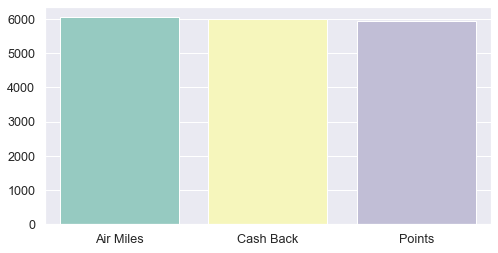

 
Column: mailer_type

Distribution:
Postcard    0.51
Letter      0.49



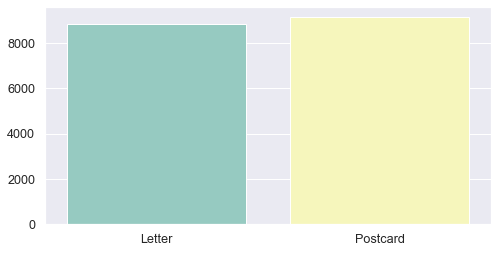

 
Column: income_level

Distribution:
Medium    0.50
High      0.25
Low       0.25



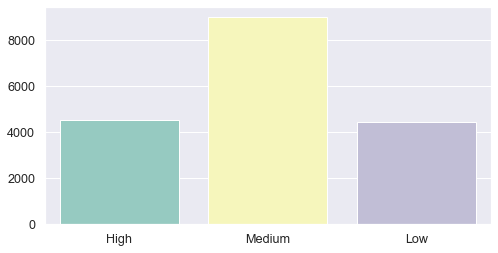

 
Column: overdraft_protection

Distribution:
No     0.85
Yes    0.15



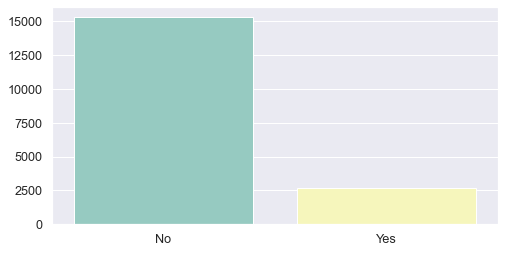

 
Column: credit_rating

Distribution:
High      0.34
Medium    0.33
Low       0.33



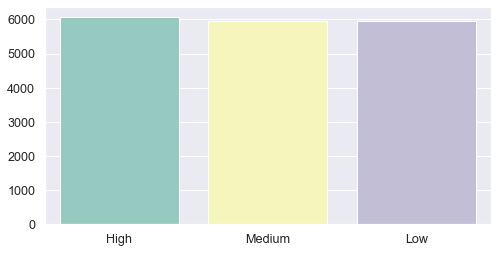

 
Column: own_your_home

Distribution:
Yes    0.65
No     0.35



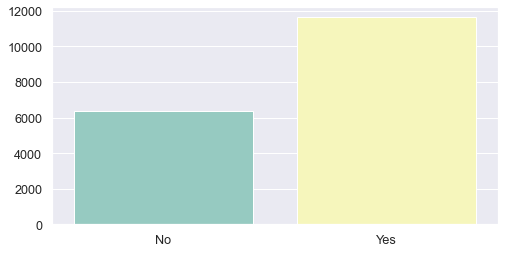

In [8]:
 categoricals_distribution(data)

## Exploring numericals

In [9]:
data.describe().round(0).astype(int)

,customer_number,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance
count,17976,17976,17976,17976,17976,17976,17976,17976,17976
mean,9000,1,2,1,3,941,910,999,1042
std,5197,0,1,0,1,350,620,457,553
min,1,1,1,1,1,48,0,0,0
25%,4499,1,1,1,3,788,393,663,633
50%,9000,1,2,1,3,1007,772,1032,946
75%,13501,1,2,1,4,1153,1521,1342,1463
max,18000,3,4,3,9,3366,3450,3421,3823


In [10]:
data_num = data.select_dtypes('number')
data_num.head()

,customer_number,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance
0,1,1,2,1,4,1160.75,1669,877,1095
1,2,1,2,2,5,147.25,39,106,78
2,3,2,2,1,2,276.50,367,352,145
3,4,2,1,1,4,1219.00,1578,1760,1119
4,5,1,2,1,6,1211.00,2140,1357,982


In [11]:
def numericals_distribution(data):
    for column in data_num.columns:
        fig, axes = plt.subplots(1, 2, figsize=(14,4))
        sns.distplot(data_num[column],ax=axes[0],color='green')
        plt.ylabel('')
        sns.boxplot(data_num[column], ax=axes[1],color='orange')
        plt.ylabel('')        
        sns.set(font_scale=1.15)
        print(' \n','Column:',column)
        plt.show()

 
 Column: customer_number


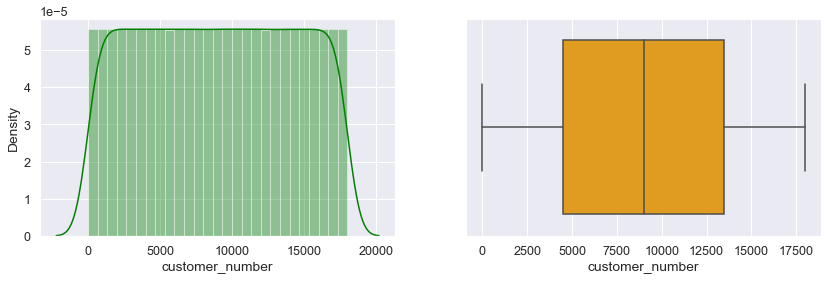

 
 Column: bank_accounts_open


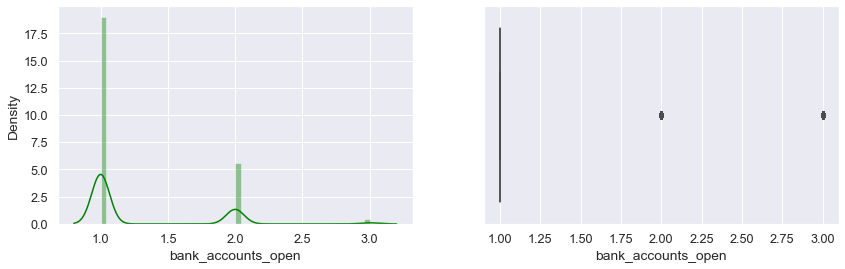

 
 Column: credit_cards_held


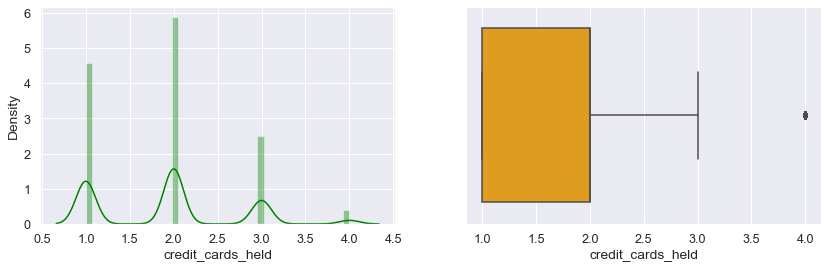

 
 Column: homes_owned


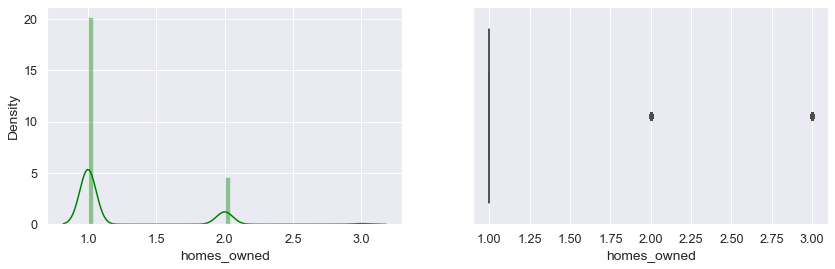

 
 Column: household_size


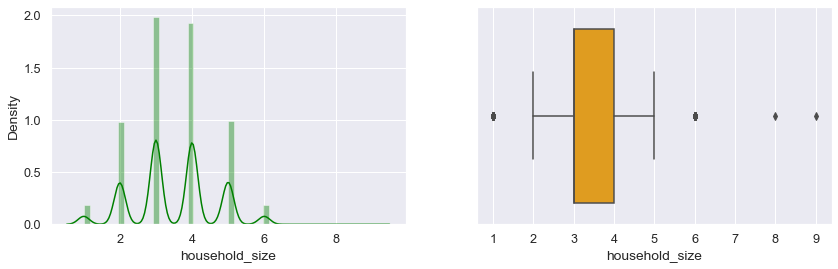

 
 Column: average_balance


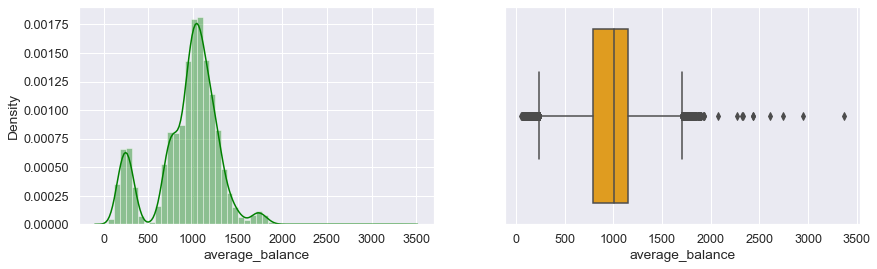

 
 Column: q1_balance


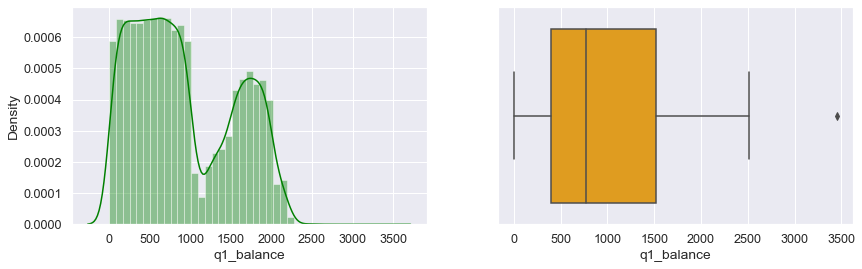

 
 Column: q2_balance


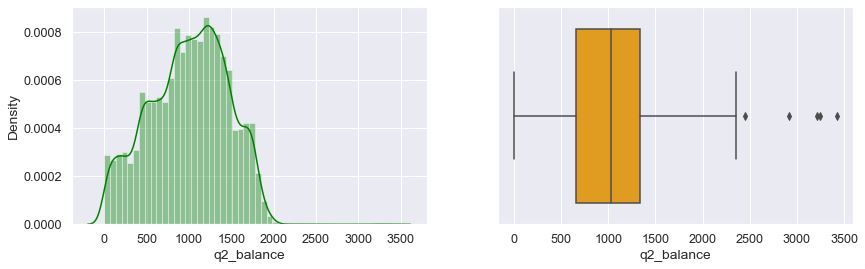

 
 Column: q3_balance


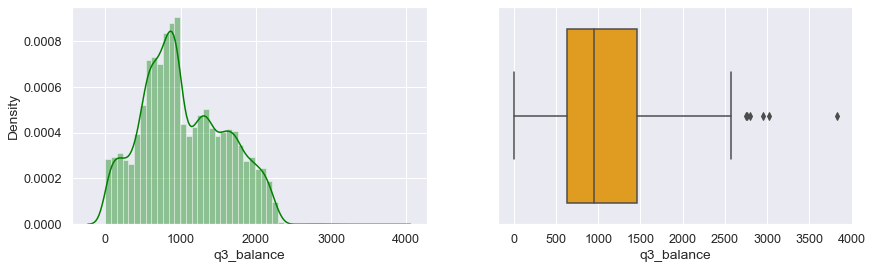

In [12]:
numericals_distribution(data)

I want to check distribution of customers who accepted the offer

In [13]:
target_customer = data[data['offer_accepted'] == 'Yes']

In [14]:
target_customer = target_customer.select_dtypes('number')

In [15]:
target_customer.shape

(1021, 9)

In [16]:
def target_distribution(data):
    for column in target_customer.columns:
        fig, axes = plt.subplots(1, 2, figsize=(14,4))
        sns.distplot(target_customer[column],ax=axes[0],color='green')
        plt.ylabel('')
        sns.boxplot(target_customer[column], ax=axes[1],color='orange')
        plt.ylabel('')        
        sns.set(font_scale=1.15)
        print(' \n','Column:',column)
        plt.show()

 
 Column: customer_number


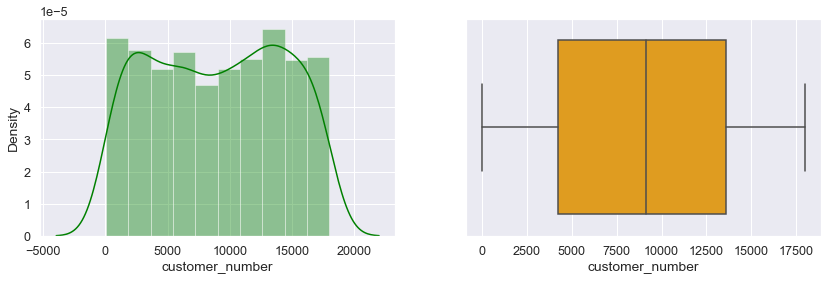

 
 Column: bank_accounts_open


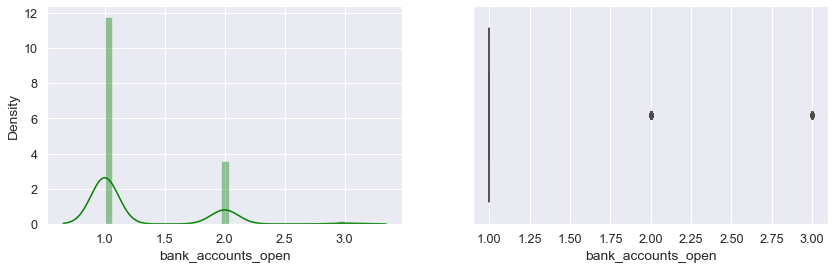

 
 Column: credit_cards_held


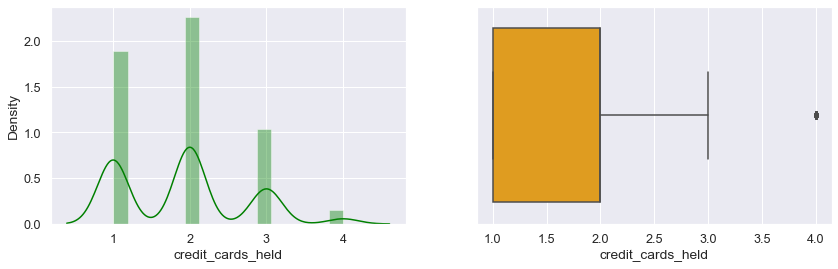

 
 Column: homes_owned


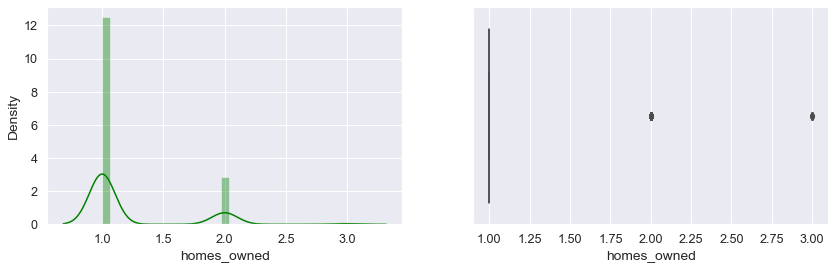

 
 Column: household_size


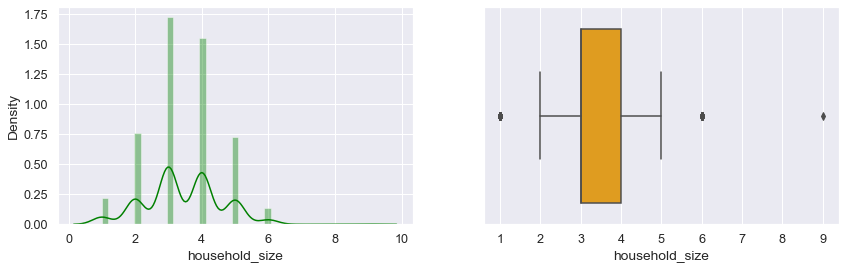

 
 Column: average_balance


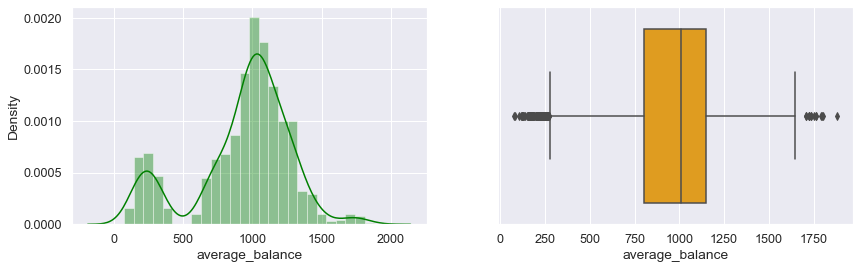

 
 Column: q1_balance


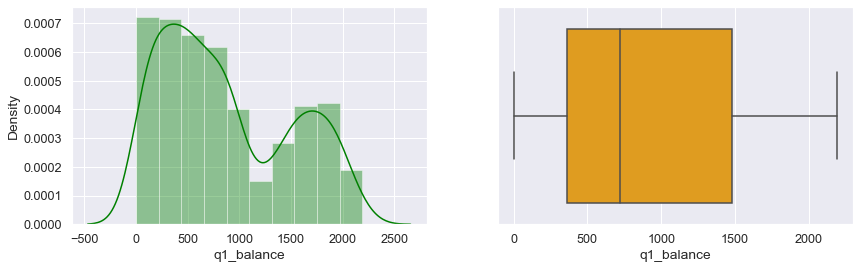

 
 Column: q2_balance


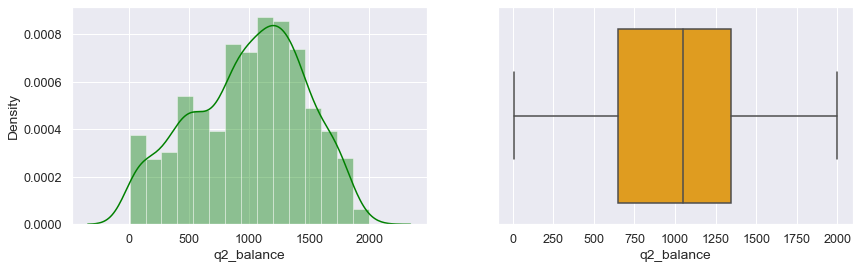

 
 Column: q3_balance


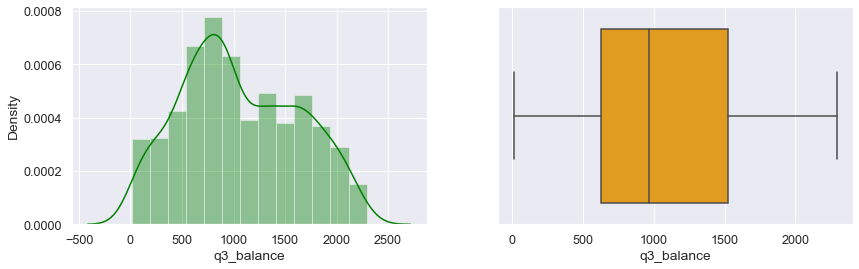

In [17]:
target_distribution(data)

## Data cleaning

In [18]:
data = data.set_index('customer_number')

## Check for multicollinearity

### Numericals: correlation matrix

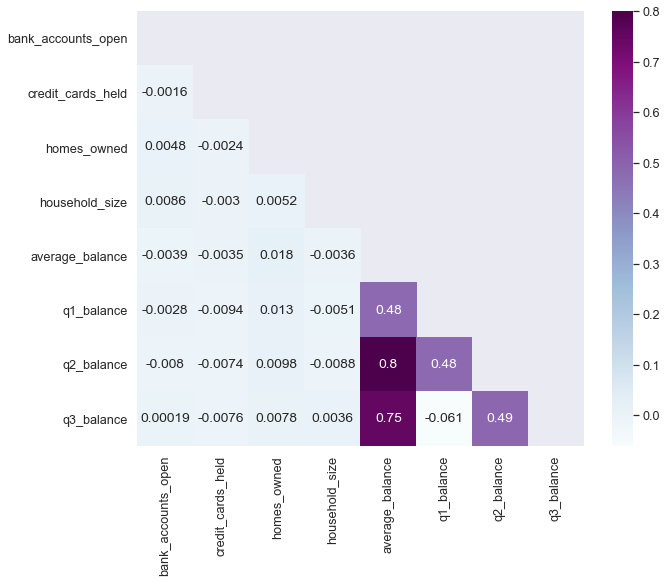

In [19]:
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True 
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(data.corr(), mask=mask, annot=True, cmap="BuPu")
sns.set_style("white")
plt.show()

### Categoricals & Numericals: VIF

In [20]:
data.columns

Index(['offer_accepted', 'reward', 'mailer_type', 'income_level',
       'bank_accounts_open', 'overdraft_protection', 'credit_rating',
       'credit_cards_held', 'homes_owned', 'household_size', 'own_your_home',
       'average_balance', 'q1_balance', 'q2_balance', 'q3_balance'],
      dtype='object')

In [21]:
features = "+".join(['reward', 'mailer_type', 'income_level',
       'bank_accounts_open', 'overdraft_protection', 'credit_rating',
       'credit_cards_held', 'homes_owned', 'household_size', 'own_your_home',
       'average_balance', 'q1_balance', 'q2_balance', 'q3_balance'])

y, X = dmatrices('offer_accepted ~' + features, data, return_type='dataframe')

In [22]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif.round(2)

,VIF Factor,features
0,48.50,Intercept
1,1.33,reward[T.Cash Back]
2,1.33,reward[T.Points]
3,1.00,mailer_type[T.Postcard]
4,1.50,income_level[T.Low]
5,1.49,income_level[T.Medium]
6,1.00,overdraft_protection[T.Yes]
7,1.33,credit_rating[T.Low]
8,1.33,credit_rating[T.Medium]
9,1.00,own_your_home[T.Yes]



I will drop q1, q2 and q3 due to high correlation with average balance as they represent the same data in a year

In [23]:
data = data.drop(['q1_balance','q2_balance','q3_balance'],axis=1)

In [24]:
data_num = data_num.drop(['q1_balance','q2_balance','q3_balance'],axis=1)

### Categoricals: Chi Square

In [25]:
def chi_square(data):
    for a in data_cat.columns:
        for b in data_cat.columns:
            if a != b:
                data_crosstab = pd.crosstab(data[a], data[b], margins = False)
                chi, p_value, degrees, table = stats.chi2_contingency(data_crosstab, correction=False)
                print('Contingency for', a, 'and', b,'\n','chi square=',chi,'\n','p_value=',p_value,'\n','degrees of freedom=',degrees,'\n')
    
    return

In [26]:
chi_square(data)

Contingency for offer_accepted and reward 
 chi square= 101.14767025681465 
 p_value= 1.0865819216542505e-22 
 degrees of freedom= 2 

Contingency for offer_accepted and mailer_type 
 chi square= 169.8785866150883 
 p_value= 7.864741197933402e-39 
 degrees of freedom= 1 

Contingency for offer_accepted and income_level 
 chi square= 113.61760484801982 
 p_value= 2.1293673159685707e-25 
 degrees of freedom= 2 

Contingency for offer_accepted and overdraft_protection 
 chi square= 0.1305604331486984 
 p_value= 0.7178516689441322 
 degrees of freedom= 1 

Contingency for offer_accepted and credit_rating 
 chi square= 445.0621419387729 
 p_value= 2.2697803189923953e-97 
 degrees of freedom= 2 

Contingency for offer_accepted and own_your_home 
 chi square= 4.459812057796639e-05 
 p_value= 0.9946716209502822 
 degrees of freedom= 1 

Contingency for reward and offer_accepted 
 chi square= 101.14767025681465 
 p_value= 1.0865819216542505e-22 
 degrees of freedom= 2 

Contingency for reward a

In [27]:
print(' \n','TABLE OF VALUES OF CHI-SQUARE DISTRIBUTION','\n')
display.Image(url="https://miro.medium.com/max/1400/1*Y8sdezeLjSolBu8Kx0wczA.png", width=750, height=300)

 
 TABLE OF VALUES OF CHI-SQUARE DISTRIBUTION 



## Feature engineering

### Categoricals encoding

In [28]:
X = data.drop('offer_accepted', axis=1)
y = data['offer_accepted']

In [29]:
X

,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance
customer_number,,,,,,,,,,,
1,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75
2,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25
3,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50
4,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00
5,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00
...,...,...,...,...,...,...,...,...,...,...,...
17996,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,167.50
17997,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,850.50
17998,Cash Back,Letter,High,1,No,Low,2,1,4,No,1087.25


In [30]:
X = pd.get_dummies(X, columns=['reward', 'mailer_type', 'income_level','overdraft_protection','credit_rating','own_your_home'])
X

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
customer_number,,,,,,,,,,,,,,,,,,,,
1,1,2,1,4,1160.75,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0
2,1,2,2,5,147.25,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1
3,2,2,1,2,276.50,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1
4,2,1,1,4,1219.00,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0
5,1,2,1,6,1211.00,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,1,1,1,5,167.50,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1
17997,1,3,1,3,850.50,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1
17998,1,2,1,4,1087.25,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0


In [31]:
y.value_counts(normalize=True)

No     0.943202
Yes    0.056798
Name: offer_accepted, dtype: float64

### Numericals (outliers, boxcox)

We will maintain the outliers as they are relevant for the model

## Train-test split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
len(X_test), len(X_train), len(y_train), len(y_test)

(3596, 14380, 14380, 3596)

## Model building

### Logistic regression

In [34]:
classification = LogisticRegression(random_state=42, max_iter=1000)

classification.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [35]:
score = classification.score(X_test, y_test)
score

0.9468854282536151

In [36]:
predictions = classification.predict(X_test)
predictions

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [37]:
y_test

customer_number
16161    No
7395     No
14670    No
17879    No
16348    No
         ..
14317    No
2395     No
7292     No
8496     No
14165    No
Name: offer_accepted, Length: 3596, dtype: object

In [38]:
predictions_ = classification.predict_proba(X_test)
predictions_

array([[0.96210225, 0.03789775],
       [0.97456167, 0.02543833],
       [0.97097527, 0.02902473],
       ...,
       [0.97447367, 0.02552633],
       [0.97314028, 0.02685972],
       [0.97482179, 0.02517821]])

#### Logistic regression confusion matrix

In [39]:
cf_matrix = confusion_matrix(y_test, predictions)
cf_matrix

array([[3405,    0],
       [ 191,    0]])

In [40]:
print(classification_report(y_test, classification.predict(X_test)))

              precision    recall  f1-score   support

          No       0.95      1.00      0.97      3405
         Yes       0.00      0.00      0.00       191

    accuracy                           0.95      3596
   macro avg       0.47      0.50      0.49      3596
weighted avg       0.90      0.95      0.92      3596



<AxesSubplot:>

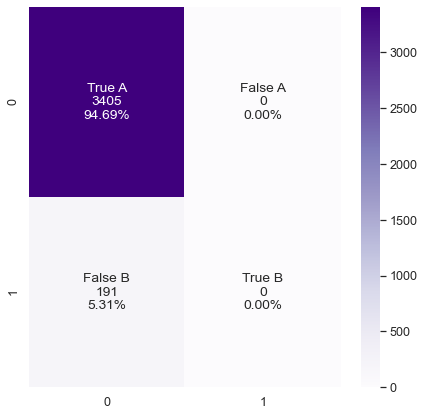

In [41]:
group_names = ['True A', 'False A', 'False B', 'True B']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(7,7))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Purples')

### KNN

In [42]:
scores = []
for i in range(2,10):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

In [43]:
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9468854282536151


Text(0, 0.5, 'Accuracy')

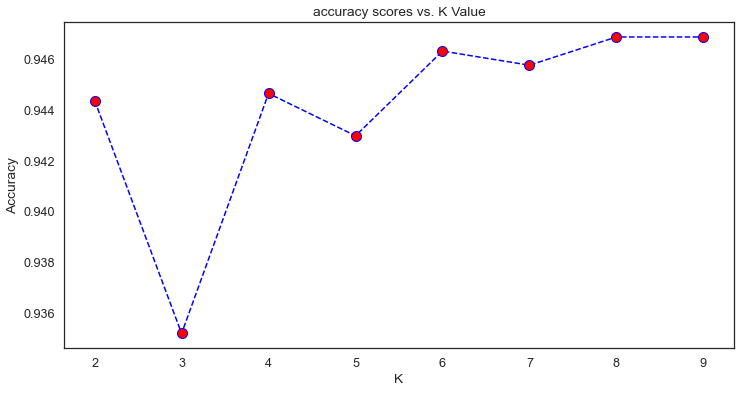

In [44]:
plt.figure(figsize=(12,6))
plt.plot(range(2,10),scores,color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('accuracy scores vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

Fit into the model with k = 5

In [45]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

KNeighborsClassifier()

#### KNN confusion matrix

In [46]:
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9454949944382648


In [47]:
predictions_knn = model.predict(X_test)
knn_cf_matrix = confusion_matrix(y_test, predictions_knn)
knn_cf_matrix

array([[3400,    5],
       [ 191,    0]])

<AxesSubplot:>

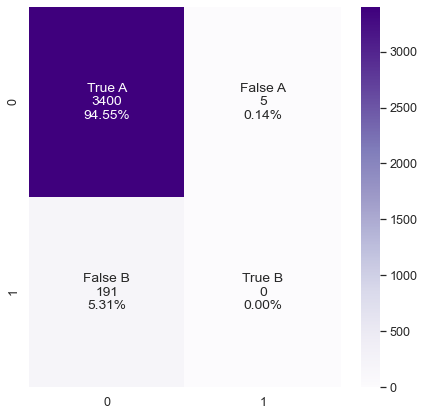

In [48]:
group_names = ['True A', 'False A', 'False B', 'True B']
group_counts = ["{0:0.0f}".format(value) for value in knn_cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in knn_cf_matrix.flatten()/np.sum(knn_cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(7,7))
sns.heatmap(knn_cf_matrix, annot=labels, fmt='', cmap='Purples')